# Multiprecision exploration
The final part of every algorithm proposed has to compute
$$ \frac{1}{n} \sum_{i=0}^{n-1} cos(x_i) $$

in this notebook I'll explore the possibility of approximating this computation.

## Original python implementation
```python
@impl(Algorithm.RS, Backend.NUMPY, [Device.CPU], description = 'array programming implementation')
def rs(x: Tensor, y: Tensor, z: Tensor, pists: Tensor, xx: Tensor, yy: Tensor, C1: float, C2: float):
    return np.angle(
        np.mean(
            np.exp(
                1j * (
                    C1 * (x[:,ε]*xx[ε,:] + y[:,ε]*yy[ε,:]) +
                    C2 * z[:,ε] * (xx**2 + yy**2)[ε,:] +
                    2*np.pi*pists[:,ε]
                )
            ),
            axis=0
        )
    )
```

I want to understand the distribution of the arrays inside the complex exponential functions. I'll pick as spots and SLM parameters values I have found [at the original repository](https://github.com/ppozzi/SLM-3dPointCloud)

# Input generation functions

In [1]:
import numpy as np
from slmporting.core.slm import SLM
from slmporting.core.types import Backend, Device
from slmporting.utils.units import Unit, Length

In [2]:
# generate points uniformely distributed in a grid (same as reference)
def generate_grid_points(n: int, size):
    lin = np.linspace(-size/2, size/2, num=n)
    x, y = np.meshgrid(lin, lin)

    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)

    return x, y, z

In [3]:
# compute the inner parenthesis
def compute_cosine_input(x, y, z, slm: SLM):
    ε = np.newaxis
    C1 = slm.C1
    C2 = slm.C2
    xx = slm.xx.convert_to(Backend.NUMPY)
    yy = slm.yy.convert_to(Backend.NUMPY)

    return C1 * (x[:,ε]*xx[ε,:] + y[:,ε]*yy[ε,:]) + \
           C2 * z[:,ε] * (xx**2 + yy**2)[ε,:]

# Results

In [4]:
# generate an SLM configuration according to specs
slm_to_pupil_magnification = 5.0 / 3.0

slm = SLM(
    focal = Length(180.0/20.0, Unit.MILLIMETERS),
    pixel_size = Length(slm_to_pupil_magnification * 9.2, Unit.MICROMETERS),
    wavelength = Length(800.0, Unit.NANOMETERS),
    resolution = 512,
)

# slm = SLM.get_standard_slm()

/home/matteo/github/slm-porting/venv/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
x, y, z = generate_grid_points(10, size=300.0)
cosine_input = compute_cosine_input(x, y, z, slm).flatten()

In [6]:
print(f'cosine_input.shape = {cosine_input.shape}')
print(f'cosine_input.size: {cosine_input.nbytes / 1024 / 1024:.2f} MB')

cosine_input.shape = (20501200,)
cosine_input.size: 156.41 MB


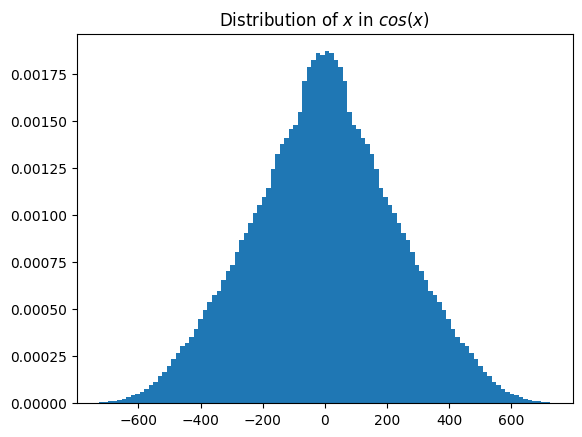

In [7]:
import matplotlib.pyplot as plt

plt.title("Distribution of $x$ in $cos(x)$")
plt.hist(cosine_input, bins = 100, density=True)
plt.show()

When the input of the cosine and sine functions is in an interval so big, approximations like taylor series will fail.

It's interesting to note that our control mechanism is to sum a random piston (which is in $[0, 2 \pi]$) to this input before taking the cosine/sine. I think that smaller float datatypes will struggle in maintaining precision both in the hundreds and in the units or tenths of units

# Multiprecision test

In [8]:
from slmporting.core.types import Algorithm, Backend, Device, DType
from slmporting.core.array import Array

In [9]:
import slmporting.impl.impl_numpy

impl = [
    impl
    for impl in slmporting.impl.impl_numpy.IMPLS
    if (impl.algorithm == Algorithm.RS)
][0]()

In [10]:
x, y, z = generate_grid_points(10, size=300.0)
pists = Array(np.random.uniform(size=x.size))
x = Array(x)
y = Array(y)
z = Array(z)

In [11]:
phase = {
    dtype: impl(x, y, z, pists, slm, dtype=dtype)[0]
    for dtype in [DType.fp32, DType.fp64]
}

In [12]:
abs_err = np.abs(phase[DType.fp64] - phase[DType.fp32])
rel_err = abs_err / np.abs(phase[DType.fp64])

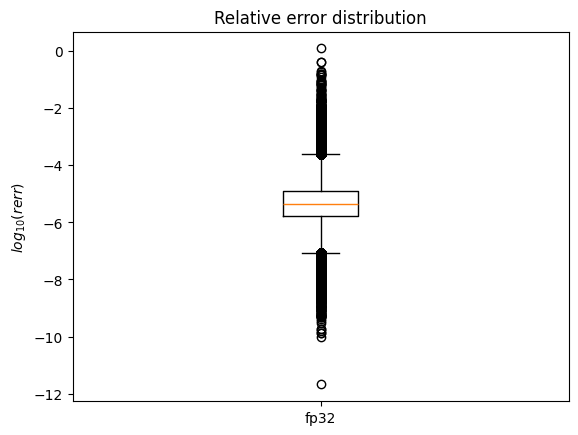

In [13]:
plt.title('Relative error distribution')
plt.boxplot(np.log10(rel_err), tick_labels=['fp32'])
plt.ylabel('$log_{10}(rerr)$')
plt.show()